# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

- Train a linear model
    - using least squares method
    - implement the model from scratch using NumPy 
    - Use learning curves plot to understand whether the linear moel is overfitting or underfitting
- Train linear models with 
    - regularization (Ridge and Lasso)
    - polynomial basis expansion
    - use validation data to choose the hyperparameters
    - scikit-learn
    - Optional task: Analyse feature importance and feature interaction (5 bonus points)

We will use the following packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

We will use the winequality dataset for this practical. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality. 
In order to make it easier to import the dataset, the dataset has been converted to the numpy array format and shuffled, so that we can start the practical directly. The converted dataset is available on the OLAT page.

#### Attribute Information
Input variables (based on physicochemical tests):

0. fixed acidity
1. volatile acidity
2. citric acid
3. residual sugar
4. chlorides
5. free sulfur dioxide
6. total sulfur dioxide
7. density
8. pH
9. sulphates
10. alcohol

Output variable (based on sensory data):

12. quality (score between 0 and 10)

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. The following code loads the data:

In [2]:
# load the white wine dataset
# X is the feature matrix that stores the feature values of the data records
# y is the label vector that stores the labels of the data records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a {} matrix, which contains {} data records and {} features.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a {}-dimentional vector, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a (4898, 11) matrix, which contains 4898 data records and 11 features.
y is a 4898-dimentional vector, which stores the corresponding labels of the data records in X


We next split the data into training data and test data. 
In practice, we should sample randomly 80% of the data as training data and the rest as the test data.  
However, in order to get consistent results, we use the first 80% of the data as training
data and the remaining as the test data. 
To achieve this split, we define the following function.

In [3]:
# The function splits the dataset into training data and testing data.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset 
# and the remaining data goes to the test dataset.
def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # split the data with split_coeff=0.8

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


## Understanding What We’re Predicting

Let’s first check
the distribution of the y-values in the training data. 
You will find that the values are integers between 3 and 9 indicating the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y-values in the training data. You will find that the y-values are integers from 3 to 9, which indicate the quality of the wines.

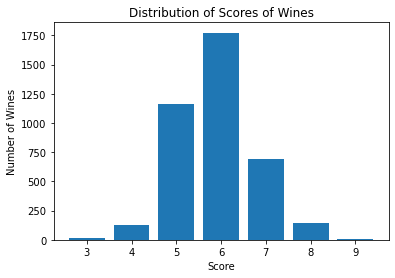

In [4]:
#@title
# Task 1: 
# the function takes the y-values in the training data as the input and makes the bar chart. 
# Hint: Your function should make a bar chart looks like the bar chart below.
def plot_bar_chart_score(y_train):
    unique, counts = np.unique(y_train, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Score')
    plt.ylabel('Number of Wines')
    plt.title('Distribution of Scores of Wines')
    plt.show()

plot_bar_chart_score(y_train)

### **Task 2** 
This task is to build a trivial predictor, which always returns the mean of the y-values of the training data. We consider the trivial model as a baseline. The linear regression models we build later should perform better than this trivial model. 

In [5]:
#@title
# Task 2: implement the trivial predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
    return np.mean(y_train)

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The trivial predictor returns the average value.
def trivial_predictor(X_test, y_train_avg):
  return y_train_avg


Average of y on the training label values is 5.878764675855028


### **Task 3**
We next evaluate the trivial predictor on the training data and test data. 
We use mean squared error (MSE) to measure the performance of the predictor.
The task is to implement a function that reports the mean squared error of the given predictor on the given data. 

In [6]:
# We next test our trivial predictor on the training data and test data. 
# Implement a function that can report the mean squared error 
# of a predictor on the given data
# Input: data and predictor
# Output: mean squared error of the predictor on the given data
def test_predictor(X, y, predictor: callable=None):
    # Apply the predictor to each row of the matrix X to get the predictions
    y_predicted = np.apply_along_axis(predictor, 1, X)

    mse = np.mean((y - y_predicted) ** 2)
    
    return mse

# use the function test_predictor to test the trivial predictor
# we use the lambda function here to pass the function trivial predictor to the function test_predictor.
mse_trivial_predictor_train = test_predictor(X_train, y_train, lambda x: trivial_predictor(x, y_train_avg))
mse_trivial_predictor_test = test_predictor(X_test, y_test, lambda x: trivial_predictor(x, y_train_avg))

# Report the result
print('Trivial Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_trivial_predictor_train)
print('MSE (Testing)  = %.4f' % mse_trivial_predictor_test)

Trivial Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Train the Linear Model Using Least Squares Method

Let us train a linear model on the training data and then check its MSE. 
We use the closed form solution of the least squares estimate to get the parameters of the linear model. 
The linear model should perform better than the trivial predictor.

### **Task 4**
Before training the model, we need to standardize the data, i.e., transform the data so that every feature has mean 0 and variance 1. 

https://en.wikipedia.org/wiki/Standard_score

We first standardize the training data. 
Then we apply the same transformation to the test data, i.e. standardize the test data using the means and the standard deviations of the training data. 

In [7]:
# The task is to implement a function that can standardize the data and returns the mean and std of the data.
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean) / std
    
    return X_std, mean, std

# Standardize the training data and store the means and the stds 
X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [8]:
# TODO: Standardize the test data using the means and standrad deviations of the training data

X_test_std = (X_test - X_train_mean) / X_train_std_div
print(X_test_std.shape)

(980, 11)


### **Task 5**
We have standardized X-values. Do we need to standardize the y-values? Why?

No, standardizing the y-values is not necessary here because we are interested in predicting the actual values of y, not relationships between data points in the feature space. Standardization of y would only be needed if the scale of y-values had an impact on the learning algorithm, which is not the case for a simple regression model.

### **Task 6**
Let's now train the linear model using the least-squares method. 
We need to add the bias term to the matrix X. 

In [9]:
# The task is to implement the function that adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    X_out = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_out

# Train the linear model using the least-squares method
# The task is to implement the function that computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the data
    X = expand_with_ones(X_input)
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    return w

# Apply the function to train the linear model
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


After computing the parameters,
we can build the linear model predictor.
The predictor takes as input the computed parameters and the data, and predicts the labels for the input data.

In [10]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    y_pred = X @ w
    return y_pred


We can now evaluate our linear model predictor on the test data. 

In [11]:
# use the function test_predictor to evaluate the linear model predictor
mse_linear_model_predictor = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283469


## Learning Curves

Let us check if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, the model shouldn't be overfitting. 
To check it, we need to check the learning curves, i.e. how the performance of the model changes when it is trained with increasingly more data. 
We train the model on the increasingly more data ([20, 40, ..., 600] data records), and evaluate the model by computing the MSE of the model on both the training data and the test data. 
We use the collected MSE to build the learning curves plot. 

### **Task 7** 

Let's first implement a function that comprises what we have implemented above. 
The function takes as inputs the data and the split coefficient, and
1. standardizes the data,
2. trains the linear model, and
3. reports the mse of the linear model predictor on both training and test datasets. 

In [12]:
# Input: training data and test data
# Output: mse of the linear model predictor on both the training and test data
def train_and_test(X_train, y_train, X_test, y_test):
    X_train_std, mean, std = standardize_data(X_train)
    w = least_squares_compute_parameters(X_train_std, y_train)
    X_test_std = (X_test - mean) / std
    y_train_pred = linear_model_predictor(expand_with_ones(X_train_std), w)
    y_test_pred = linear_model_predictor(expand_with_ones(X_test_std), w)
    
    mse_train = np.mean((y_train - y_train_pred) ** 2)
    mse_test = np.mean((y_test - y_test_pred) ** 2)
    
    return mse_train, mse_test

mse_train, mse_test = train_and_test(X_train, y_train, X_test, y_test)
print('Linear Model')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


Linear Model
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5607


We are now ready to report the learning curves.
The task is to train the linear model on the increasingly more data ([20, 40, ..., 600] data records)
and store the MSE of the trained model on the training data and the test data in the lists `mse_train_v` and `mse_test`, respectively. 
We have provided the code for generating the learning curves from `mse_train_v` and `mse_test`.

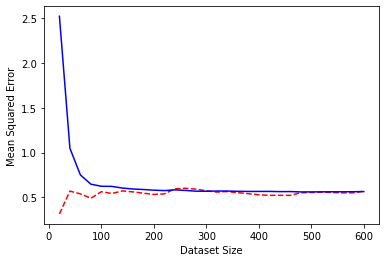

In [13]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the MSE over data with sizes from TRAINING_SIZE_MIN to TRAINING_SIZE_MAX with increasing step 20
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    X_train_subset = X_train[:train_size]
    y_train_subset = y_train[:train_size]
    
    mse_train, mse_test = train_and_test(X_train_subset, y_train_subset, X_test, y_test)
    
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)
    

# The below code generates the learning curves plot
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

### **Task 8**
Explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

The model is not underfitting. The optimal test error is achieved when adding more data stops reducing it significantly.

## Polynomial Basis Expansion and Regularisation

In this part, we will try to improve the linear model by basis expansion and regularisation. 

The task is to 
1. apply the degree 2 basis expansion to the data, 
2. build the Ridge and Lasso models using scikit-learn, and
3. perform hyperparameter optimization to find the optimal hyperparameter lambda. 

For the hyperparameter optimization, you should set the last 20% of the training data for the purpose of validation and 
try lambda values [10^-4, 10^-3, 10^-2, 10^-1, 1, 10, 100]. 


We will use the scikit-learn package. You can import other scikit-learn packages if you think they are useful. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html

In [14]:
# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [15]:
def expand_basis(X, degree):
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X)
    return X

### **Task 10**
We need to expand and standardize the the data,
and prepare the training, test and validation data on the expanded data. 
You should set the last 20% of the training data as the validation data.

Hints: use `StandardScaler` and `std_scaler` to standardize the data

In [16]:
def prepare_data(X, y, degree):
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)
    
    std_scaler = StandardScaler()
    X_train = std_scaler.fit_transform(X_train)
    X_test = std_scaler.transform(X_test)
    
    X_train = expand_basis(X_train, degree)
    X_test = expand_basis(X_test, degree)
    
    std_scaler_expanded = StandardScaler()
    X_train = std_scaler_expanded.fit_transform(X_train)
    X_test = std_scaler_expanded.transform(X_test)
    
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)
    
    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test


X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

**Why standardisation is required before basis expansion?**

Assume we have a dataset with two features x1 and x2, where x1 has a small scale while x2 has a large scale. When we perform basis expansion, we  get a new feature x1x2. Since x2 has a larger scale than x1, it is likely x2 will contribute more to the value of the new feature x1x2, which means a bias is introduce here. 
The correct way is to standardise the features before the basis expansion. In this case x1 and x2 have the same scale, so they contribute same to the new feature x1x2, i.e. no bias is introduced. 


**Why standardise the training data in step 5?**

Ridge and Lasso regularisation require the data to have mean of 0 and standard deviation of 1. However, after the basis expansion and splitting in step 4, the training data might not have the desired distribution, so we need to perform the standardisation on the training data. 

 
**Why not standardise both training and validation data together?**

When we use validation data to chose the hyperparameters, we treat the validation data like the test data -- we should not assume we can access these data. So we should standardise the training data and perform the same operation to the validation data. 

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyperparameter lambda for Ridge and Lasso using the validation data. 
We use the Ridge and Lasso models from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

We train Ridge or Lasso models with different lambda values and check their performance on the validation data.
The lambda value that results the best performance is then the optimal lambda. 

Ridge lambda: 1
Lasso lambda: 0.0001


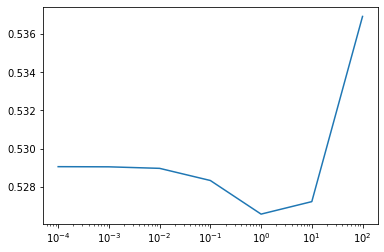

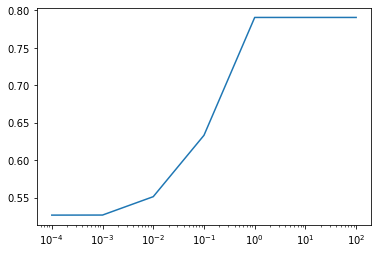

In [17]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that results the minimal mse
# We use is_ridge to indicate which the model is considered.
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    # Try lambda values from 10^-4 to 10^2. 
    # Record the mse and the lambda values in mse_arr and lam_arr
    for pow_lam in range(-4, 3):
        lam = 10 ** pow_lam
        
        if is_ridge:
            model = Ridge(alpha=lam)
        else:
            model = Lasso(alpha=lam, max_iter=10000, tol=0.01)  # Increased max_iter and set a tolerance
        
        model.fit(X_train_n, y_train_n)
        y_pred_v = model.predict(X_train_v)
        mse = np.mean((y_train_v - y_pred_v) ** 2)
        
        mse_arr.append(mse) 
        lam_arr.append(lam)


    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the optimal lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal lambdas for Ridge and Lasso, train these models using these lambdas on the full training data. Then report
the training and test error.

In [18]:
# TODO: train the Ridge and Lasso models using the optimal parameters, and
#       report their MSE
ridge_model = Ridge(alpha=lam_ridge)
ridge_model.fit(X_train, y_train)

y_pred_ridge_train = ridge_model.predict(X_train)
y_pred_ridge_test = ridge_model.predict(X_test)

mse_ridge_train = np.mean((y_train - y_pred_ridge_train) ** 2)
mse_ridge_test = np.mean((y_test - y_pred_ridge_test) ** 2)

lasso_model = Lasso(alpha=lam_lasso, max_iter=10000, tol=0.01)
lasso_model.fit(X_train, y_train)

y_pred_lasso_train = lasso_model.predict(X_train)
y_pred_lasso_test = lasso_model.predict(X_test)

mse_lasso_train = np.mean((y_train - y_pred_lasso_train) ** 2)
mse_lasso_test = np.mean((y_test - y_pred_lasso_test) ** 2)

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 1.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4952
MSE (Testing)  = 0.5126


For Lasso with using degree 2 polynomial expansion and lambda = 0.0001
---------------------------------------------------------------------

MSE (Training) = 0.4953
MSE (Testing)  = 0.5122


## **Task 13 Optional**: Feature importance and feature interaction

This is an optional task. You can get up to 5 bonus points if you complete this task.

The task is to identify the features that contribute the most and the least to the prediction, and to explore feature interaction. First, we are evaluating the performance of linear regression models that use only one feature each. We train one model for every feature and report the MSE for each model. Then, we train a linear regression model on all features and analyse the contribution of each feature to the prediction. 
In addition, you will practice the k-fold cross-validation method.

In this optional task, you may use the `cross_val_score` function and `LinearRegression` class from the scikit-learn library. We import both below.

Note, if you use the `LinearRegression` class with its default parameters, then you do not need to add the bias term to the data. The `LinearRegression` class will add the bias automatically.

Proceed as follows:

1. Split the data into training and test data. Use the first 80% of the data for training and the remaining 20% for testing.

2. Standardize the training data and test data. You can use the `StandardScaler` function from the scikit-learn library.

3. Use the `cross_val_score` function to train one linear regression model for every feature. The function returns an array with the MSE for each fold. You can use the `mean` function from the NumPy library to compute the average MSE for each feature. (use the following parameters: `cv=5`, `scoring='neg_mean_squared_error'`)

4. Plot the average MSE for each feature (Note, the `cross_val_score` function returns the negative MSE. Plot the positive values by multipling with $-1$). Use the `bar` function from the matplotlib library to plot the MSEs.

5. **Report which single-feature model performs best and which performs worst.**

6. Train a linear regression model on the training data and report the coefficients of the model. Use the `LinearRegression` class from the scikit-learn library and extract the coefficients using the `coef_` attribute. 

7. **Plot the coefficients using the `bar` function from the matplotlib library.**

8. Compare the coefficients of the feature that achieved the smallest and largest MSE in step 3 with the coefficients of the model trained in step 6.

9. **Answer the following questions:** 
    - What do the model coefficients tell us about the contribution of each feature to the prediction?
    - Identify and report the features that contribute the most and the least to the model trained in step 6.
    - How do the coefficients of the model trained in step 6 compare to the insigths gained from the single-feature models? Is the most important feature according to the single-feature models also the highest contributing feature according to the model trained on all features? If not, why do you think this is the case?
    - If the volatile acidity of a wine increases, how does this impact the quality of the wine according to the model trained in step 6?


In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

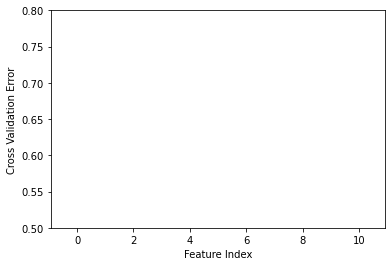

In [20]:
#X_train, y_train, X_test, y_test = split_data(X, y, 0.8)

###################################################
##### YOUR CODE STARTS HERE #######################
###################################################

n_features = 11
cross_val_err = np.zeros(n_features)

# standardize the data

# train one model for each feature and compute the cross validation error


###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

# plot the cross validation error as bar chart
plt.figure()
plt.bar(np.arange(n_features), cross_val_err)
plt.xlabel('Feature Index')
plt.ylabel('Cross Validation Error')
plt.ylim([0.5, 0.8])
plt.show()


**Describe which single feature model performs best and which performs worst.**

**YOUR ANSWER**


In [21]:
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################

# train the linear model using the full training data

# extract the coefficients of the linear model

# plot the coefficients in the order of their feature index


###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

**YOUR ANSWERS TO THE QUESTIONS IN STEP 9**